In [1]:
import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName")
sc = SparkContext(conf=conf)


In [2]:
# initialise spark context
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.types import *

# making sqlContext object
sqlContext = SQLContext(sc)


# get python and spark versions and displaying
import platform
print(platform.python_version())
print(sc.version)

# import python sql libraries and other functions 
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# import python library for plotting data
import matplotlib.pyplot as plt
import gmplot

#import pandas and numpy
import pandas as pd
#import numpy as np

3.6.8
2.4.3


In [3]:
# Read the files and create RDDpolice
# 48 files are read for two year data for two forces
rdd_police = sc.textFile("hdfs:///user/imat5322_255595/202*.csv").map(lambda l:l.split(','))

In [4]:
# total row count including headers
rdd_police.count()

608499

In [5]:
# identifies header for RDDpolice and store in new variable
header = rdd_police.first()

In [6]:
# displays columns for the entire data set
display(header)

['Crime ID',
 'Month',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA code',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context']

In [7]:
# filter data without headers and assign to new variable as new RDD
# new rdd here is filtered with data without the headers
filtered_without_header = rdd_police.filter(lambda line:line!=header)

# the count shows the rows after excluding the headers
filtered_without_header.count()

608451

In [8]:
# check first 10 row entries after removing the header rows
filtered_without_header.take(3)

[['eb7d4ea385808814b3eabbf97cb8f4d5102b30e3a886f21ca202db00289a5eac',
  '2020-01',
  'Essex Police',
  'Essex Police',
  '0.853468',
  '51.130815',
  'On or near Hextable Close',
  'E01024019',
  'Ashford 008B',
  'Violence and sexual offences',
  'Unable to prosecute suspect',
  ''],
 ['a65cf6c1cb3ac2a1f21a7090bd6c3438e68f1c4467f263279902e70ee811dfdc',
  '2020-01',
  'Essex Police',
  'Essex Police',
  '0.853468',
  '51.130815',
  'On or near Hextable Close',
  'E01024019',
  'Ashford 008B',
  'Violence and sexual offences',
  'Unable to prosecute suspect',
  ''],
 ['f3dddb34dd2a0b9fbe9ccff37be62b3b8c105e8e85d8b94f13e241bd2f1ddc19',
  '2020-01',
  'Essex Police',
  'Essex Police',
  '0.758726',
  '52.068846',
  'On or near Browns Close',
  'E01029923',
  'Babergh 006D',
  'Violence and sexual offences',
  'Court result unavailable',
  '']]

In [9]:
# preprocessing the data
# Mapping column names to row entries with new header name
column_name_updates = filtered_without_header.map(lambda x:Row(Crime_ID=x[0] ,Month=x[1], \
                                    Reported_by=x[2],Falls_within=x[3],Longitude=x[4],Latitude=x[5],\
                                    Location=x[6],  Crime_type=x[9], LSOA_code=x[7], LSOA_name=x[8],\
                                    Last_outcome_category=x[10], Context=x[11]))


In [10]:
# creating dataframe using sqlContext
police_results = sqlContext.createDataFrame(column_name_updates)

In [11]:
# checking schema
police_results.printSchema()

root
 |-- Context: string (nullable = true)
 |-- Crime_ID: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)



In [12]:
# displaying 200 records for the data
police_results.show(200)

+-------+--------------------+--------------------+------------+---------+--------------------+---------------------+---------+--------------------+---------+-------+------------+
|Context|            Crime_ID|          Crime_type|Falls_within|LSOA_code|           LSOA_name|Last_outcome_category| Latitude|            Location|Longitude|  Month| Reported_by|
+-------+--------------------+--------------------+------------+---------+--------------------+---------------------+---------+--------------------+---------+-------+------------+
|       |eb7d4ea385808814b...|Violence and sexu...|Essex Police|E01024019|        Ashford 008B| Unable to prosecu...|51.130815|On or near Hextab...| 0.853468|2020-01|Essex Police|
|       |a65cf6c1cb3ac2a1f...|Violence and sexu...|Essex Police|E01024019|        Ashford 008B| Unable to prosecu...|51.130815|On or near Hextab...| 0.853468|2020-01|Essex Police|
|       |f3dddb34dd2a0b9fb...|Violence and sexu...|Essex Police|E01029923|        Babergh 006D| Cour

In [13]:
# total crime records found
police_results.count()

608451

In [14]:
# data filteration
# filtering those crimes that are with known ID
# data filtered and assigned to new variable excluding all records for column 'Crime_ID' with none/empty values
crime_rdd = police_results.filter(police_results["Crime_ID"]!="")


In [15]:
# data filteration and preprocessing
# filtering those crimes having location empty
# data filtered and assigned to new variable excluding all records for 'location' with none/empty values
crime_rdd = crime_rdd.filter(crime_rdd["LSOA_code"]!="")

# displays records left after more filteration 
crime_rdd.count()

482927

In [16]:
# output crime data to pandas for better obcervation
crime_data_table = crime_rdd.toPandas()

# to visualize the records in table form, showing using pandas.
crime_data_table

,Context,Crime_ID,Crime_type,Falls_within,LSOA_code,LSOA_name,Last_outcome_category,Latitude,Location,Longitude,Month,Reported_by
0,,eb7d4ea385808814b3eabbf97cb8f4d5102b30e3a886f2...,Violence and sexual offences,Essex Police,E01024019,Ashford 008B,Unable to prosecute suspect,51.130815,On or near Hextable Close,0.853468,2020-01,Essex Police
1,,a65cf6c1cb3ac2a1f21a7090bd6c3438e68f1c4467f263...,Violence and sexual offences,Essex Police,E01024019,Ashford 008B,Unable to prosecute suspect,51.130815,On or near Hextable Close,0.853468,2020-01,Essex Police
2,,f3dddb34dd2a0b9fbe9ccff37be62b3b8c105e8e85d8b9...,Violence and sexual offences,Essex Police,E01029923,Babergh 006D,Court result unavailable,52.068846,On or near Browns Close,0.758726,2020-01,Essex Police
3,,fb0e86e8d5f4aa7faa58281360ddc87fec89c0b3bfc1dd...,Violence and sexual offences,Essex Police,E01029919,Babergh 007G,Unable to prosecute suspect,52.036236,On or near Church Street,0.723995,2020-01,Essex Police
4,,47cf621b5ae93d2a3a94a858c4f5cabce96f5847def560...,Violence and sexual offences,Essex Police,E01029919,Babergh 007G,Unable to prosecute suspect,52.036236,On or near Church Street,0.723995,2020-01,Essex Police
...,...,...,...,...,...,...,...,...,...,...,...,...
482922,,c04fa178ab1dcb7a9b009212ffabcbade0f2bf9700cb7c...,Violence and sexual offences,Leicestershire Police,E01026315,South Kesteven 009A,Unable to prosecute suspect,52.892424,On or near Cobleas,-0.759665,2021-12,Leicestershire Police
482923,,6a433dbddd1e8b827cc8e31249c2da2bebb401d7cdbca2...,Violence and sexual offences,Leicestershire Police,E01026315,South Kesteven 009A,Unable to prosecute suspect,52.892424,On or near Cobleas,-0.759665,2021-12,Leicestershire Police
482924,,1d81e839dc94cf3f4616bbce4784546729e03ff5e7c3e2...,Other crime,Leicestershire Police,E01026330,South Kesteven 012A,Investigation complete; no suspect identified,52.711714,On or near Sports/Recreation Area,-0.445269,2021-12,Leicestershire Police
482925,,a14e1eb4efa01989b1e729f22b5d5cdabc8c39e9eb6b0b...,Vehicle crime,Leicestershire Police,E01026356,South Kesteven 016D,Investigation complete; no suspect identified,52.663081,On or near Meadowsweet,-0.516480,2021-12,Leicestershire Police


In [17]:
# Total crimes with known crime id
crime_rdd.count()

482927

In [18]:
# filtering the crimes with respect to crime type
vehicle_crimes = crime_rdd.filter(crime_rdd["Crime_type"]=="Vehicle crime")

In [19]:
# displays total vehicle type total crime count
vehicle_crimes.count()

34088

In [20]:
# total crimes in 2021 for both forces
crime_rdd.filter((crime_rdd["Month"]>="2021-01") & (crime_rdd["Month"]<="2021-12")).count()

247486

In [21]:
# total crimes in 2020 for both forces
crime_rdd.filter((crime_rdd["Month"]>="2020-01") & (crime_rdd["Month"]<="2020-12")).count()

235441

In [22]:
# here we are droping the context column, as it not useful mostly having empty values
filtered_rdd = crime_rdd.drop("Context")

In [23]:
filtered_rdd.count()

482927

In [24]:
#  get total crimes falls within Essex for 2 years
filtered_rdd.filter((filtered_rdd["Falls_within"]=="Essex Police") & 
                    ((filtered_rdd["Month"]>="2020-01") & (filtered_rdd["Month"]<="2021-12"))).count()    

313722

In [25]:
#  get total crimes falls within Leicestershire for 2 years
filtered_rdd.filter((filtered_rdd["Falls_within"]=="Leicestershire Police") & 
                    ((filtered_rdd["Month"]>="2020-01") & (filtered_rdd["Month"]<="2021-12"))).count()

169205

In [26]:
# Convert datatype from (string to float) for the fields required.
type_changes = filtered_rdd.withColumn("Latitude",filtered_rdd["Latitude"].cast(FloatType()))
crime_filtered_data = type_changes.withColumn("Longitude",filtered_rdd["Longitude"].cast(FloatType()))


In [27]:
# shows updated schema after data type changes
crime_filtered_data.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Location: string (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)



In [28]:
# Register the DataFrame as a table
sqlContext.registerDataFrameAsTable(crime_filtered_data, "crimedata_table")

In [29]:
# checking if the data loads for sql query
sqlContext.sql("select * from crimedata_table").take(5)

[Row(Crime_ID='eb7d4ea385808814b3eabbf97cb8f4d5102b30e3a886f21ca202db00289a5eac', Crime_type='Violence and sexual offences', Falls_within='Essex Police', LSOA_code='E01024019', LSOA_name='Ashford 008B', Last_outcome_category='Unable to prosecute suspect', Latitude=51.13081359863281, Location='On or near Hextable Close', Longitude=0.8534680008888245, Month='2020-01', Reported_by='Essex Police'),
 Row(Crime_ID='a65cf6c1cb3ac2a1f21a7090bd6c3438e68f1c4467f263279902e70ee811dfdc', Crime_type='Violence and sexual offences', Falls_within='Essex Police', LSOA_code='E01024019', LSOA_name='Ashford 008B', Last_outcome_category='Unable to prosecute suspect', Latitude=51.13081359863281, Location='On or near Hextable Close', Longitude=0.8534680008888245, Month='2020-01', Reported_by='Essex Police'),
 Row(Crime_ID='f3dddb34dd2a0b9fbe9ccff37be62b3b8c105e8e85d8b94f13e241bd2f1ddc19', Crime_type='Violence and sexual offences', Falls_within='Essex Police', LSOA_code='E01029923', LSOA_name='Babergh 006D', L

In [30]:
# Total rows returns the types of crimes
sqlContext.sql("select distinct Crime_type from crimedata_table").show()

+--------------------+
|          Crime_type|
+--------------------+
|      Charnwood 021E|
|       Bicycle theft|
|        Public order|
|               Drugs|
|         Other crime|
|             Robbery|
|Criminal damage a...|
|      Charnwood 022D|
|Theft from the pe...|
|         Shoplifting|
|            Burglary|
|         Other theft|
|Possession of wea...|
|          Blaby 013C|
|Violence and sexu...|
|       Vehicle crime|
|      Charnwood 012C|
+--------------------+



In [31]:
# rows returns the total crime count for each month over-all
# highest crime count appears at top for the entire month
sqlContext.sql("select Month, count(Crime_ID) as crime_count from crimedata_table group by Month \
               order by crime_count desc").show(24)

+-------+-----------+
|  Month|crime_count|
+-------+-----------+
|2021-10|      22789|
|2021-07|      22785|
|2021-06|      22140|
|2020-08|      21945|
|2021-05|      21814|
|2021-11|      21781|
|2021-09|      21514|
|2020-01|      21420|
|2021-08|      21398|
|2020-09|      21072|
|2020-07|      21051|
|2021-12|      20510|
|2020-10|      20212|
|2021-03|      19931|
|2021-04|      19923|
|2020-06|      19859|
|2020-02|      19764|
|2020-11|      19214|
|2020-03|      18661|
|2020-05|      18599|
|2020-12|      17452|
|2021-01|      16558|
|2021-02|      16343|
|2020-04|      16192|
+-------+-----------+



In [32]:
# rows return the total crime count for each month for Essex
# highest crime count appears at top for the entire month
sqlContext.sql("select Month, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Essex Police' \
               group by Month \
               order by crime_count desc").show(24)

+-------+-----------+
|  Month|crime_count|
+-------+-----------+
|2021-07|      15202|
|2020-08|      14602|
|2021-10|      14580|
|2021-05|      14328|
|2020-01|      14212|
|2021-06|      14029|
|2020-07|      14010|
|2021-09|      13866|
|2021-08|      13849|
|2021-11|      13843|
|2020-09|      13687|
|2020-02|      13280|
|2020-06|      13092|
|2020-10|      12999|
|2021-12|      12999|
|2020-03|      12735|
|2021-03|      12724|
|2021-04|      12695|
|2020-11|      12265|
|2020-05|      12135|
|2020-12|      11146|
|2021-02|      10524|
|2021-01|      10471|
|2020-04|      10449|
+-------+-----------+



In [33]:
# rows returned the total crime count for each month for Leicestershire
# highest crime count appears at top for the entire month
sqlContext.sql("select Month, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Leicestershire Police' \
               group by Month \
               order by crime_count desc").show(24)

+-------+-----------+
|  Month|crime_count|
+-------+-----------+
|2021-10|       8209|
|2021-06|       8111|
|2021-11|       7938|
|2021-09|       7648|
|2021-07|       7583|
|2021-08|       7549|
|2021-12|       7511|
|2021-05|       7486|
|2020-09|       7385|
|2020-08|       7343|
|2021-04|       7228|
|2020-10|       7213|
|2020-01|       7208|
|2021-03|       7207|
|2020-07|       7041|
|2020-11|       6949|
|2020-06|       6767|
|2020-02|       6484|
|2020-05|       6464|
|2020-12|       6306|
|2021-01|       6087|
|2020-03|       5926|
|2021-02|       5819|
|2020-04|       5743|
+-------+-----------+



In [34]:
# total crime rates in Leicestershire with respect to crime type
# crime type with maximum value is on top 
sqlContext.sql("select Crime_type, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Leicestershire Police' \
               group by Crime_type \
               order by crime_count desc").show()

+--------------------+-----------+
|          Crime_type|crime_count|
+--------------------+-----------+
|Violence and sexu...|      71578|
|        Public order|      21986|
|Criminal damage a...|      18763|
|         Other theft|      13645|
|       Vehicle crime|      11606|
|            Burglary|       8446|
|         Shoplifting|       6064|
|               Drugs|       5988|
|         Other crime|       4167|
|       Bicycle theft|       2818|
|Possession of wea...|       1464|
|             Robbery|       1432|
|Theft from the pe...|       1161|
|      Charnwood 021E|         59|
|      Charnwood 022D|         14|
|          Blaby 013C|          9|
|      Charnwood 012C|          5|
+--------------------+-----------+



In [35]:
# total crimes rates in Essex
# crime type with maximum value is on top 
sqlContext.sql("select Crime_type, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Essex Police' \
               group by Crime_type \
               order by crime_count desc").show()

+--------------------+-----------+
|          Crime_type|crime_count|
+--------------------+-----------+
|Violence and sexu...|     147931|
|        Public order|      33566|
|Criminal damage a...|      29633|
|       Vehicle crime|      22482|
|         Other theft|      20872|
|         Shoplifting|      15256|
|            Burglary|      13948|
|               Drugs|      12693|
|         Other crime|       6935|
|       Bicycle theft|       3279|
|             Robbery|       2565|
|Possession of wea...|       2534|
|Theft from the pe...|       2028|
+--------------------+-----------+



In [36]:
# Crime areas in Leicestershire with total crimes
# showing top 15 areas with their names and total crimes
sqlContext.sql("select LSOA_name, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Leicestershire Police' \
               group by LSOA_name \
               order by crime_count desc").show(15)

+--------------------+-----------+
|           LSOA_name|crime_count|
+--------------------+-----------+
|      Leicester 041A|       6521|
|      Leicester 008B|       1841|
|      Charnwood 003A|       1791|
|      Leicester 041D|       1643|
|      Leicester 004A|       1563|
|      Leicester 040B|       1539|
|      Leicester 023C|       1354|
|      Leicester 040A|       1235|
|Hinckley and Bosw...|       1153|
|      Leicester 030C|       1113|
|          Blaby 006C|       1087|
|      Charnwood 002A|       1057|
|      Leicester 038A|       1037|
|      Leicester 023A|        979|
|      Leicester 009B|        845|
+--------------------+-----------+
only showing top 15 rows



In [37]:
# Crime areas in Essex with total crimes
# showing top 15 areas with their names and total crimes
sqlContext.sql("select LSOA_name, count(Crime_ID) as crime_count from crimedata_table \
               where Falls_within == 'Essex Police' \
               group by LSOA_name \
               order by crime_count desc").show(15)

+--------------------+-----------+
|           LSOA_name|crime_count|
+--------------------+-----------+
|       Basildon 015C|       3503|
|     Colchester 007D|       3010|
|Southend-on-Sea 010A|       2975|
|Southend-on-Sea 015B|       2948|
|     Chelmsford 010G|       2651|
|       Tendring 016B|       2315|
|         Harlow 007E|       2286|
|       Thurrock 015C|       2246|
|     Chelmsford 010F|       2086|
|       Thurrock 015B|       2040|
|Southend-on-Sea 014C|       1708|
|       Tendring 018A|       1549|
|     Colchester 004B|       1395|
|     Uttlesford 006B|       1316|
|       Thurrock 017D|       1297|
+--------------------+-----------+
only showing top 15 rows



In [38]:
# Total unique locations in Leicester and Essex with total crimes
sqlContext.sql("select Falls_within, count(Falls_within) as crime_count,\
               count(distinct LSOA_code) as total_crime_location from crimedata_table \
               group by Falls_within \
               order by crime_count desc").show()

+--------------------+-----------+--------------------+
|        Falls_within|crime_count|total_crime_location|
+--------------------+-----------+--------------------+
|        Essex Police|     313722|                1810|
|Leicestershire Po...|     169205|                 705|
+--------------------+-----------+--------------------+



In [39]:
import pixiedust

Pixiedust database opened successfully



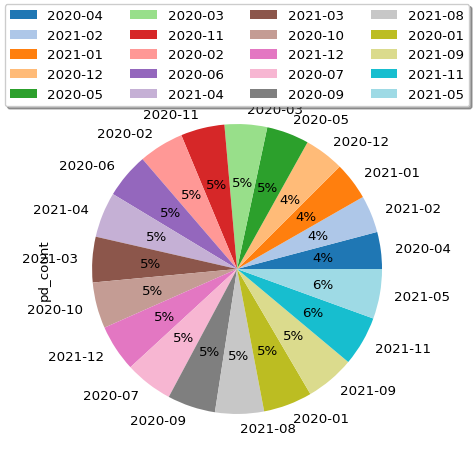

In [40]:
# loading data via pixiedust for visualization
# percentage of over all crimes w.r.t months
display(crime_filtered_data)

In [41]:
# crime trends over the year for both forces
display(crime_filtered_data)


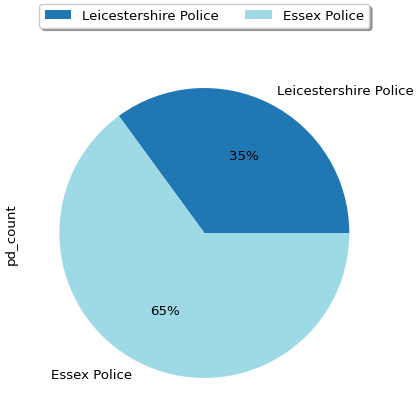

In [42]:
# pie chart showing crime crime percentage division across forces
display(crime_filtered_data)


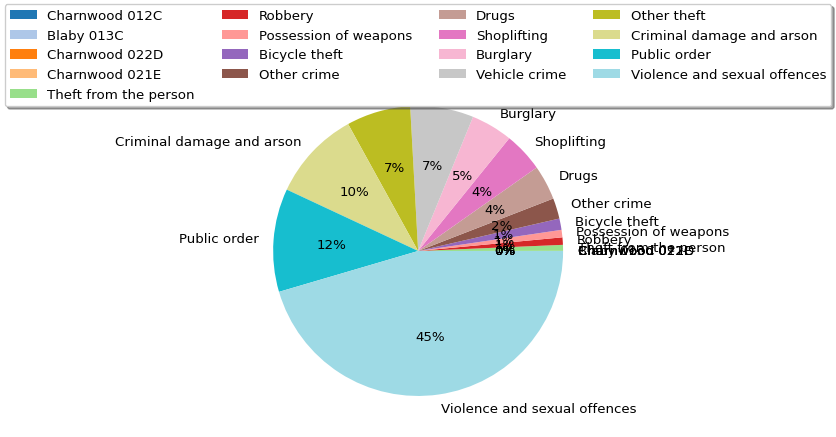

In [43]:
# crime percentage with respect to Crime Type
display(crime_filtered_data)


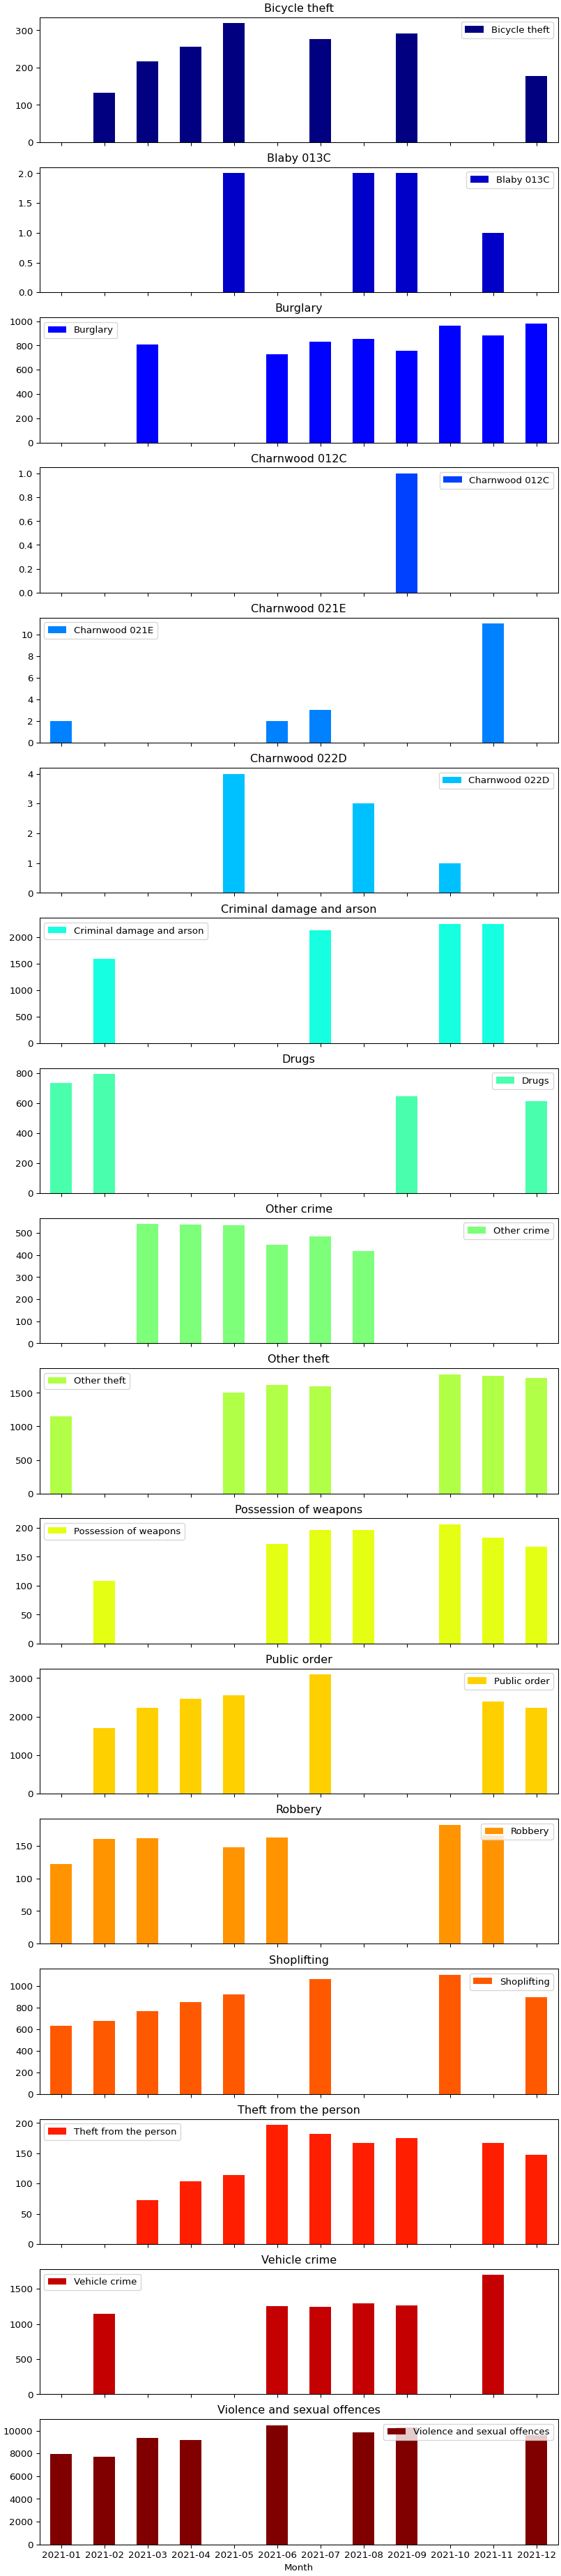

In [44]:
# Each crime trends across the months
display(crime_filtered_data)


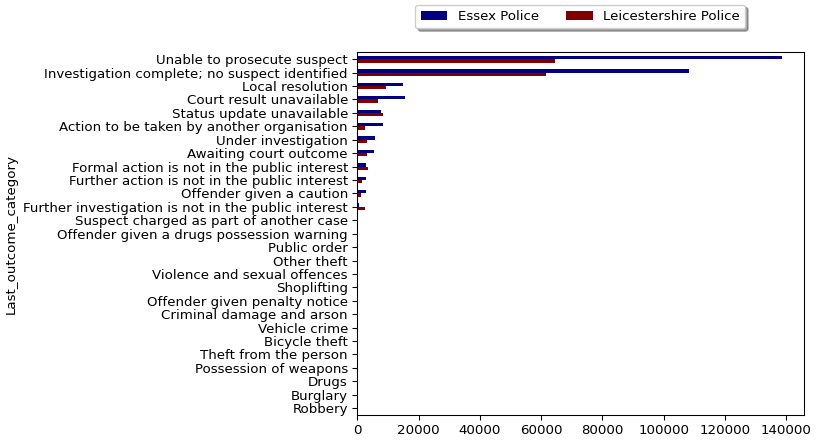

In [ ]:
# last outcomes of all crime types over two years (2020,2021)
display(crime_filtered_data)


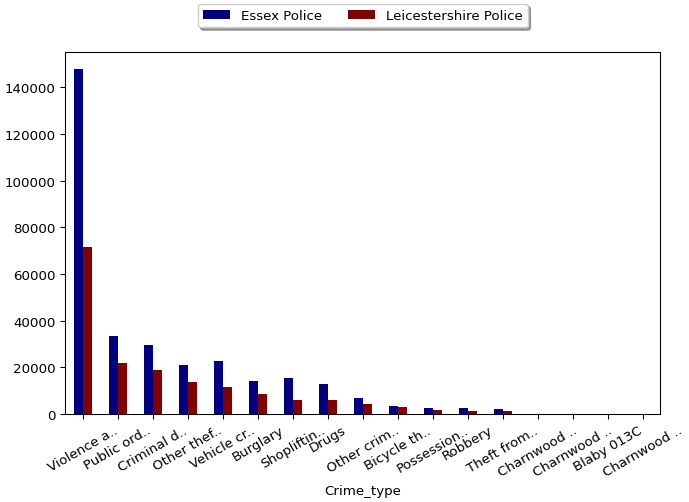

In [46]:
# All crime types over two years (2020,2021) for both forces
display(crime_filtered_data)


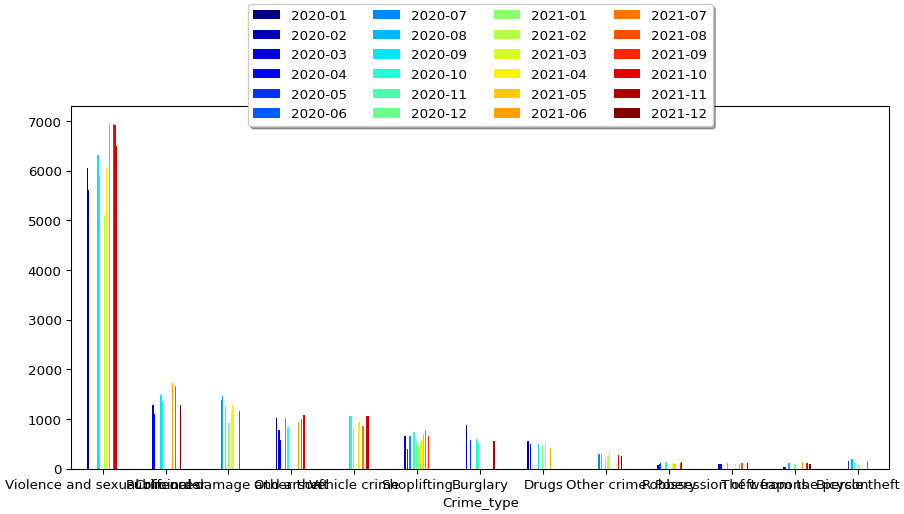

In [47]:
# all crime types trend in each month
display(crime_filtered_data)

In [48]:
# density maps for showing crime count in the respective region (add region in filters)
display(crime_filtered_data)